<a href="https://colab.research.google.com/github/Termote/Deep_learning_for_optical_imaging/blob/main/Final_project_DefeatChatGPT_opti_nicolas_ZA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Data

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Activation
from keras.layers import Conv2D, MaxPooling2D,TimeDistributed, Concatenate, Conv3D, MaxPooling3D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import cv2
import os
import gdown



In [ ]:
# Download the data training folder
url = "https://drive.google.com/drive/folders/15tqljOBNINQ1nh54yFzhZvPcbRJi5RSd"
gdown.download_folder(url, quiet=True, use_cookies=False)



['/content/Project Files/Data Description.docx',
 '/content/Project Files/Project presentation.pdf',
 '/content/Project Files/Sample_Network_GPT.ipynb',
 '/content/Project Files/Training Data/common_time.npy',
 '/content/Project Files/Training Data/ground_truth.npy',
 '/content/Project Files/Training Data/labels.npy',
 '/content/Project Files/Training Data/meteo_data.csv',
 '/content/Project Files/Training Data/X1.npy',
 '/content/Project Files/Training Data/X2.npy']

In [ ]:
import pandas as pd
import os

# File paths and corresponding column names
file_columns = [('/content/Project Files/Training Data/common_time.npy', 'common_time'),
                ('/content/Project Files/Training Data/ground_truth.npy', 'ground_truth'),
                ('/content/Project Files/Training Data/labels.npy', 'labels'),
                ('/content/Project Files/Training Data/meteo_data.csv', 'meteo_data')]
# Create an empty DataFrame
combined_df = pd.DataFrame()

# Load and add data to the DataFrame
for file_path, column_name in file_columns:
    if file_path.endswith('.npy'):
        data = np.load(file_path, allow_pickle=True)
        df = pd.DataFrame(data, columns=[column_name])
        combined_df = pd.concat([combined_df, df], axis=1)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        df.columns = [f"{column_name}_{col}" for col in df.columns]
        combined_df = pd.concat([combined_df, df], axis=1)

# Display the combined DataFrame
print("Combined DataFrame:")

#remove one of the date columns
combined_df = combined_df.drop('meteo_data_time', axis=1)
print(combined_df.shape)
combined_df.head(5)

Combined DataFrame:
(10000, 6)


,common_time,ground_truth,labels,meteo_data_Air_temp,meteo_data_Wind_speed,meteo_data_Wind_dir
0,2021-12-06 08:50:00,21.0,132.0,1.6,1.0,324
1,2021-12-06 09:10:00,34.0,126.0,1.8,1.2,331
2,2021-12-06 09:20:00,52.0,136.0,1.7,1.7,329
3,2021-12-06 09:30:00,70.0,143.0,1.8,1.3,325
4,2021-12-06 09:50:00,82.0,134.0,1.9,1.0,326


In [ ]:
# Load images
x1 = np.load('/content/Project Files/Training Data/X1.npy')
x2 = np.load('/content/Project Files/Training Data/X2.npy')


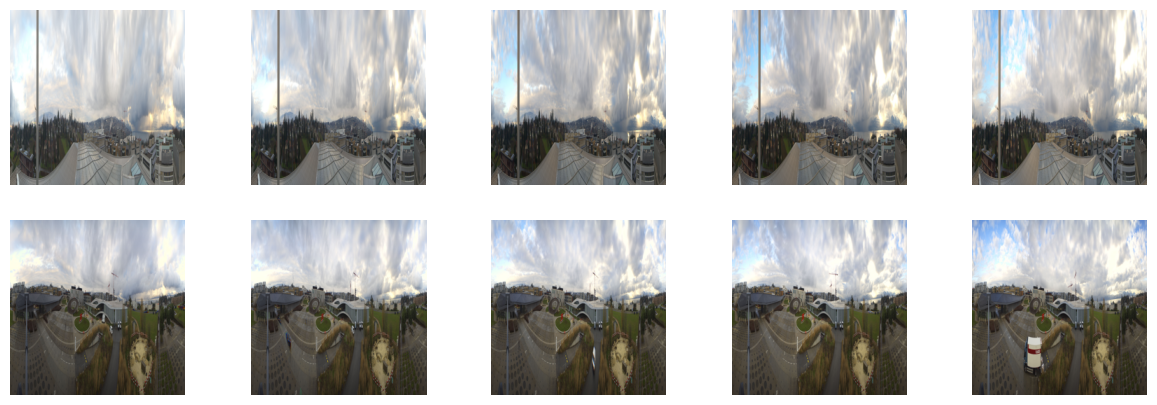

x1 shape:  (10000, 250, 250, 3)
x2 shape:  (10000, 250, 250, 3)


In [ ]:
# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(15, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2[i])
    axes[1, i].axis('off')

plt.show()

print("x1 shape: ", x1.shape)
print("x2 shape: ", x2.shape)

In [ ]:
# Resizing the images to new dimensions

# take only every two images and combined_df
x1 = x1[::3]
x2 = x2[::3]
combined_df = combined_df.iloc[::3]

new_dim = 100
image_crop_percent = 0 # (top, bottom, left, right)
side_dim_scaled = (new_dim, int(new_dim * (1 - image_crop_percent)))

x1_resized = np.array([cv2.resize(img, (new_dim, new_dim)) for img in x1])
del x1
# crop the images
x1_resized = x1_resized[:, 0:int(x1_resized.shape[1]*(1-image_crop_percent))]

x2_resized = np.array([cv2.resize(img, (new_dim, new_dim)) for img in x2])
del x2
# crop the images
x2_resized = x2_resized[:, 0:int(x2_resized.shape[1]*(1-image_crop_percent))]

# normalize the images

x1_resized = x1_resized / 255.0
x2_resized = x2_resized / 255.0

new_dim = (x1_resized.shape[1], x1_resized.shape[2])

x1_resized shape:  (3334, 100, 100, 3)
x2_resized shape:  (3334, 100, 100, 3)


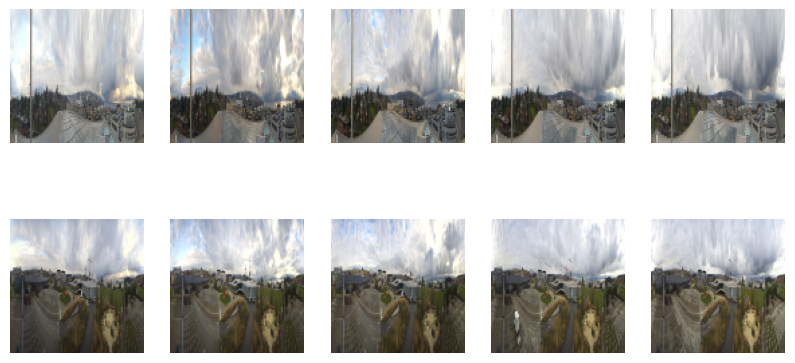

In [ ]:
print("x1_resized shape: ", x1_resized.shape)
print("x2_resized shape: ", x2_resized.shape)

# Create a subplot with two rows and five columns
fig, axes = plt.subplots(2, 5, figsize=(10, 5))

# Display images in the subplot
for i in range(5):
    axes[0, i].imshow(x1_resized[i])
    axes[0, i].axis('off')
    axes[1, i].imshow(x2_resized[i])
    axes[1, i].axis('off')

plt.show()

In [ ]:
#Split data

def date_to_cyclic(day, month, hour):
    c_day = np.cos(day * (2 * np.pi / 31))
    s_day = np.sin(day * (2 * np.pi / 31))
    c_month = np.cos(month * (2 * np.pi / 12))
    s_month = np.sin(month * (2 * np.pi / 12))
    c_hour = np.cos(hour * (2 * np.pi / 24))
    s_hour = np.sin(hour * (2 * np.pi / 24))

    return c_day, s_day, c_month, s_month, c_hour, s_hour

def split_train_test(data, train_test_ratio):
    train_size = int(len(data) * train_test_ratio)
    return data[:train_size], data[train_size:]

def create_train_test(train_test_ratio):

    date = combined_df['common_time']
    # convert to datetime
    date = pd.to_datetime(date)
    # extract the month
    month = date.dt.month
    # extract the day
    day = date.dt.day
    # extract the hour
    hour = date.dt.hour

    # convert to cyclic
    c_day, s_day, c_month, s_month, c_hour, s_hour = date_to_cyclic(day, month, hour)
    
    columns = ['meteo_data_Wind_speed', 'meteo_data_Wind_dir', 'meteo_data_Air_temp','ground_truth']
    meteo_data = combined_df[columns]
    meteo_data = np.array(meteo_data)

    # Add cyclic date to meteo_data
    meteo_data = np.concatenate((meteo_data, c_day[:, None], s_day[:, None], c_month[:, None], s_month[:, None], c_hour[:, None], s_hour[:, None], day[:, None], month[:, None], hour[:, None]), axis=1)

    labels = combined_df['labels']
    labels = np.array(labels)

    train_x1, test_x1 = split_train_test(x1_resized, train_test_ratio)
    train_x2, test_x2 = split_train_test(x2_resized, train_test_ratio)

    train_data, test_data = split_train_test(meteo_data, train_test_ratio)

    y_train, y_test = split_train_test(labels, train_test_ratio)

    X_images_train = np.stack((train_x1, train_x2), 1)
    X_images_test = np.stack((test_x1, test_x2), 1)

    # Shuffle the data for training
    idx = np.random.permutation(len(X_images_train))

    X_images_train, X_data_train, y_train = X_images_train[idx], train_data[idx], y_train[idx]

    return X_images_train, X_data_train, X_images_test, test_data, y_train, y_test


train_test_ratio = 0.9

X_images_train, X_data_train, X_images_test, X_data_test, y_train, y_test = create_train_test(train_test_ratio)

print("X_images_train shape:", X_images_train.shape)
print("X_data_train shape:", X_data_train.shape)
print("X_images_test shape:", X_images_test.shape)
print("X_data_test shape:", X_data_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

del x1_resized
del x2_resized

<ipython-input-8-88d69dd534ed>:37: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  meteo_data = np.concatenate((meteo_data, c_day[:, None], s_day[:, None], c_month[:, None], s_month[:, None], c_hour[:, None], s_hour[:, None], day[:, None], month[:, None], hour[:, None]), axis=1)


X_images_train shape: (3000, 2, 100, 100, 3)
X_data_train shape: (3000, 13)
X_images_test shape: (334, 2, 100, 100, 3)
X_data_test shape: (334, 13)
y_train shape: (3000,)
y_test shape: (334,)


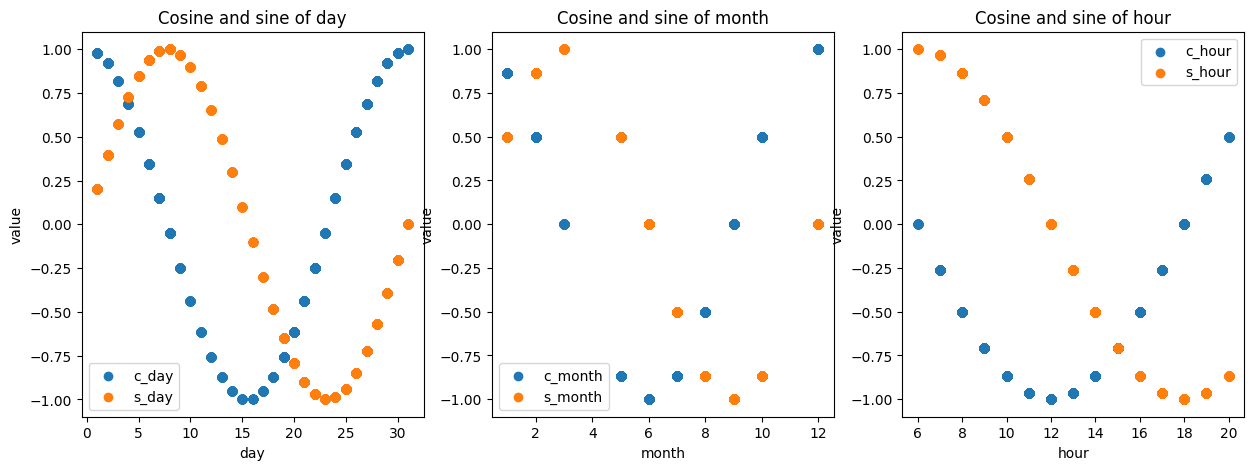

In [ ]:
# Plot the cyclid data, use month and day hour as x-axis

day_y = X_data_train[:, -3]
month_y = X_data_train[:, -2]
hour_y = X_data_train[:, -1]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot cosine and sine of day
axes[0].scatter(day_y, X_data_train[:, 4], label='c_day')
axes[0].scatter(day_y, X_data_train[:, 5], label='s_day')
axes[0].set_xlabel('day')
axes[0].set_ylabel('value')
axes[0].set_title('Cosine and sine of day')
axes[0].legend()

# Plot cosine and sine of month
axes[1].scatter(month_y, X_data_train[:, 6], label='c_month')
axes[1].scatter(month_y, X_data_train[:, 7], label='s_month')
axes[1].set_xlabel('month')
axes[1].set_ylabel('value')
axes[1].set_title('Cosine and sine of month')
axes[1].legend()

# Plot cosine and sine of hour
axes[2].scatter(hour_y, X_data_train[:, 8], label='c_hour')
axes[2].scatter(hour_y, X_data_train[:, 9], label='s_hour')
axes[2].set_xlabel('hour')
axes[2].set_ylabel('value')
axes[2].set_title('Cosine and sine of hour')
axes[2].legend()

plt.show()





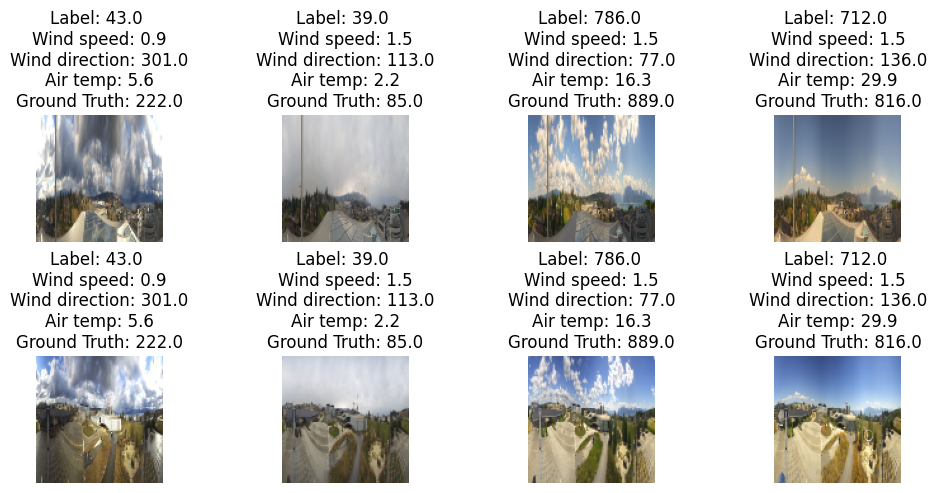

In [ ]:
# print the first 2 images with labels and corresponding wind speed

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

# Display images in the subplot
for i in range(4):

    axes[0, i].imshow(X_images_train[i][0])
    axes[0, i].axis('off')
    # plot title as label and wind speed
    axes[0, i].set_title("Label: {} \nWind speed: {}\nWind direction: {}\nAir temp: {}\nGround Truth: {}".format(y_train[i], X_data_train[i,0],X_data_train[i,1],X_data_train[i,2],X_data_train[i,3]))
    axes[1, i].imshow(X_images_train[i][1])
    axes[1, i].axis('off')
    axes[1, i].set_title("Label: {} \nWind speed: {}\nWind direction: {}\nAir temp: {}\nGround Truth: {}".format(y_train[i], X_data_train[i,0],X_data_train[i,1],X_data_train[i,2],X_data_train[i,3]))

plt.tight_layout()
plt.show()


ChatGPT model


In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import (
    Input,
    Reshape,
    LSTM,
    Dense,
    TimeDistributed,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Flatten,
    GRU,
    ConvLSTM2D,
    MultiHeadAttention,
    LayerNormalization,
    GlobalMaxPooling2D
)

In [ ]:
#Add a dimension to X_data_train and X_data_test to make them n,1,13 instead of n,13
X_data_train = np.expand_dims(X_data_train, axis=1)
X_data_test = np.expand_dims(X_data_test, axis=1)

channels = 3

In [ ]:
# define the parameters
lr = 0.001
use_transformer = False
use_gru = True
use_convlstm = True


In [ ]:
input_image = Input(shape=(2, new_dim[0], new_dim[1], channels), name='image_input')
input_data = Input(shape=(X_data_train.shape[2],), name='weather_data_input')

# Reshape data input for LSTM
input_data = Reshape((1, -1))(input_data)

data_input = LSTM(32, return_sequences=True)(input_data)
data_input = Dense(32, activation='relu')(data_input)
data_input = Dense(8, activation='relu')(data_input)

# CNN Block 1
image_conv = TimeDistributed(Conv2D(8, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(input_image)
image_conv = TimeDistributed(MaxPooling2D(pool_size=2))(image_conv)
image_conv = TimeDistributed(Conv2D(8, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(image_conv)
image_conv = TimeDistributed(MaxPooling2D(pool_size=2))(image_conv)

# Add dropout to reduce overfitting
image_conv = TimeDistributed(Dropout(0.1))(image_conv)

# CNN Block 2

if not use_convlstm : 
  image_conv = TimeDistributed(Conv2D(16, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(image_conv)
  image_conv = TimeDistributed(MaxPooling2D(pool_size=2))(image_conv)
  image_conv = TimeDistributed(Conv2D(16, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))(image_conv)
  image_conv = TimeDistributed(MaxPooling2D(pool_size=2))(image_conv)
  image_conv = TimeDistributed(Dropout(0.1))(image_conv)
else : 
  image_conv = ConvLSTM2D(16, kernel_size=3, activation='relu', return_sequences=True,kernel_regularizer=tf.keras.regularizers.l2(0.01))(image_conv)
  image_conv = ConvLSTM2D(16, kernel_size=3, activation='relu')(image_conv)
  image_conv = MaxPooling2D(pool_size=2)(image_conv)
  image_conv = Dropout(0.1)(image_conv)

# TODO : LAYER NORMALIZATION
#image_conv = LayerNormalization(epsilon=1e-6)(image_conv)

# Flattening and Reshaping for LSTM
flt = TimeDistributed(Flatten())(image_conv)
flt = Reshape((1, -1))(flt)

# Concatenating CNN and data input
concat = tf.keras.layers.concatenate([flt, data_input])

# LSTM
lstm1 = tf.keras.layers.LSTM(32, activation='relu', return_sequences=False)(concat)
lstm1 = Reshape((1, -1))(lstm1)

# GRU
gru_output = GRU(32, activation='relu', return_sequences=False)(concat)
gru_output = Reshape((1, -1))(gru_output)

# Transformers
transformer = MultiHeadAttention(num_heads=4, key_dim=32)
transformer_output = transformer(flt, data_input)

# Concatenate only the desired layers
if use_transformer:
    final_hidden = transformer_output
elif use_gru:
    final_hidden = gru_output
else : 
    final_hidden = lstm1

# Final Dense Layers
dense1 = Dense(200, activation='relu')(final_hidden)
dense1 = Dense(1, activation='relu')(dense1)
dense1 = Flatten()(dense1)

model = tf.keras.models.Model(inputs=[input_image, input_data], outputs=dense1)

Graphical schematic of the compiled network

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 2, 100, 100  0           []                               
                                , 3)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 2, 98, 98, 8  224        ['image_input[0][0]']            
 ted)                           )                                                                 
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 2, 49, 49, 8  0          ['time_distributed[1][0]']       
 buted)                         )                

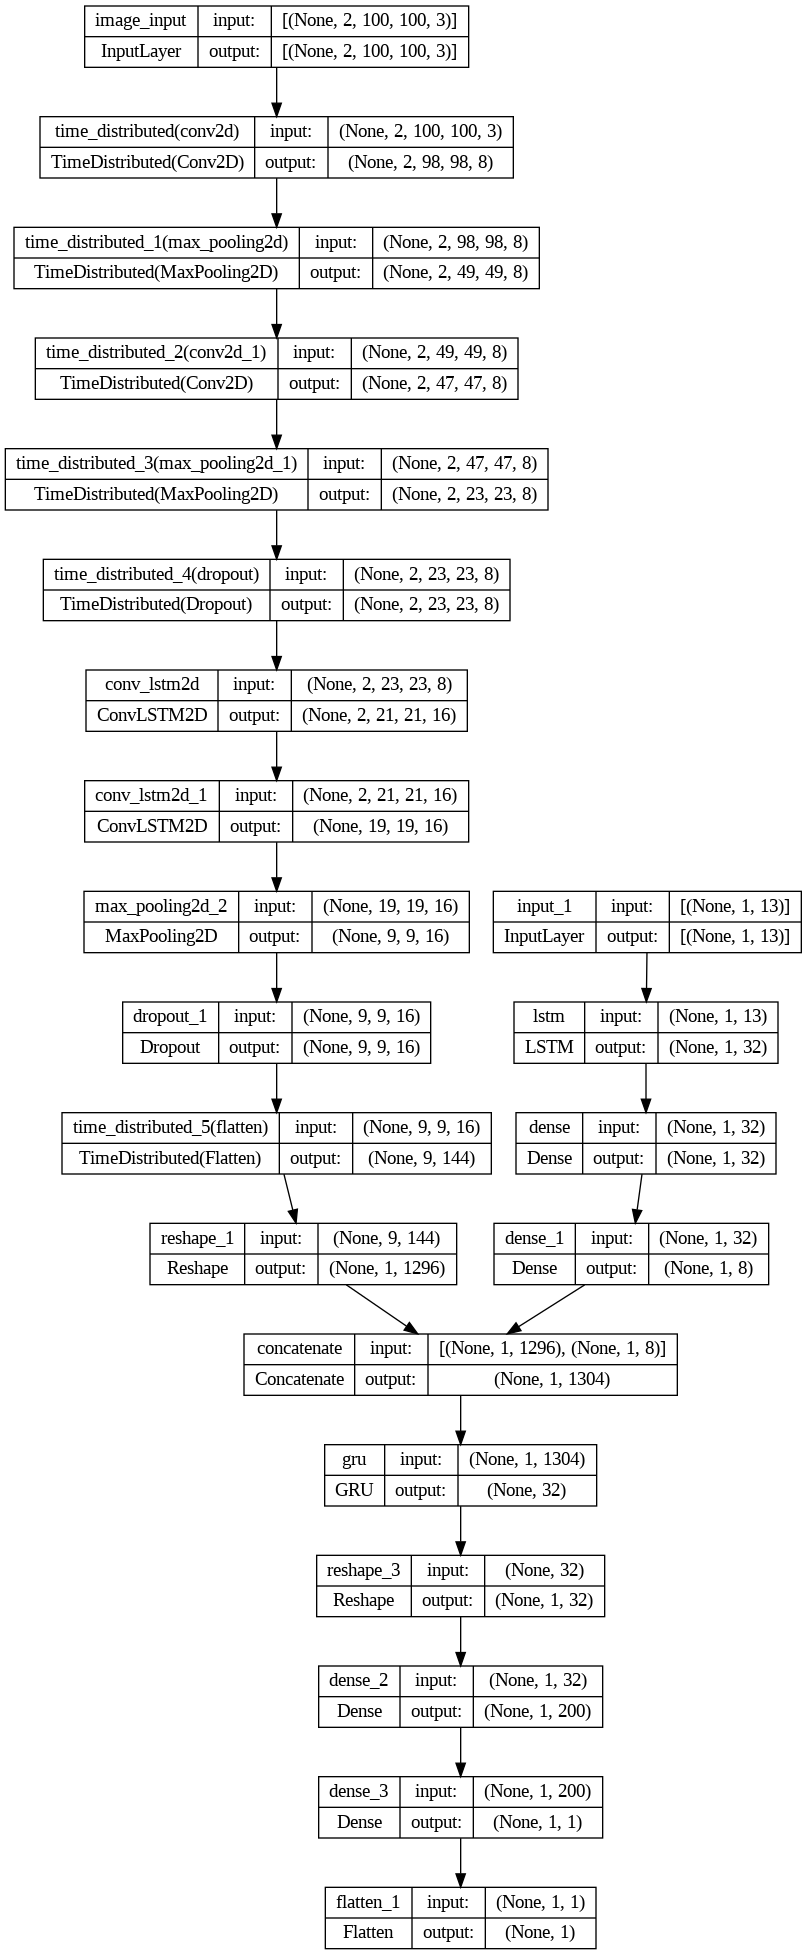

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# compile the model and use mse as loss function, use as metric accuracy or mse itself 
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=lr), metrics=['mse'])

print('Graphical schematic of the compiled network')
print()
model.summary()

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(filename='model.png')

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_list = []

def reset_model(model):

    model_copy = tf.keras.models.clone_model(model)
    model_copy.set_weights(model.get_weights())

    return model_copy


indx = 1
for i in range(indx):
    print('Training iteration: ', i+1)
    print()

    model_copy = reset_model(model)
    model_copy.compile(optimizer='adam', loss='mean_squared_error') # default lr = 0.001

    history = model_copy.fit([X_images_train, X_data_train], y_train, shuffle=True, epochs=50, batch_size=128, verbose = 2, validation_split=0.1)
    print()
    print('Training rmse: ', np.sqrt(history.history['loss'][-1]))
    print('Validation rmse: ', np.sqrt(history.history['val_loss'][-1]))

    y_pred = model_copy.predict([X_images_test, X_data_test])

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print('Test accuracy: ', rmse)
    print()
    rmse_list.append(rmse)
    if i != indx -1 :
      del model_copy
      del history

#Averaging the test accuracy after 5 times training
print('Average test rmse: ', np.mean(rmse_list))
print('Standard deviation of test rmse: ', np.std(rmse_list))

Training iteration:  1

Epoch 1/50
22/22 - 23s - loss: 169203.9375 - val_loss: 168376.9531 - 23s/epoch - 1s/step
Epoch 2/50
22/22 - 1s - loss: 169203.8594 - val_loss: 168376.9219 - 1s/epoch - 67ms/step
Epoch 3/50
22/22 - 1s - loss: 169203.7969 - val_loss: 168376.8594 - 1s/epoch - 67ms/step
Epoch 4/50
22/22 - 2s - loss: 169203.7500 - val_loss: 168376.8281 - 2s/epoch - 70ms/step
Epoch 5/50
22/22 - 1s - loss: 169203.7500 - val_loss: 168376.8281 - 1s/epoch - 68ms/step
Epoch 6/50
22/22 - 1s - loss: 169203.7500 - val_loss: 168376.8281 - 1s/epoch - 67ms/step
Epoch 7/50
22/22 - 1s - loss: 169203.7031 - val_loss: 168376.7969 - 1s/epoch - 67ms/step
Epoch 8/50
22/22 - 1s - loss: 169203.7344 - val_loss: 168376.7969 - 1s/epoch - 67ms/step
Epoch 9/50
22/22 - 1s - loss: 169203.7188 - val_loss: 168376.7969 - 1s/epoch - 66ms/step
Epoch 10/50
22/22 - 1s - loss: 169203.7344 - val_loss: 168376.7969 - 1s/epoch - 66ms/step
Epoch 11/50
22/22 - 1s - loss: 169203.7188 - val_loss: 168376.7969 - 1s/epoch - 66ms/

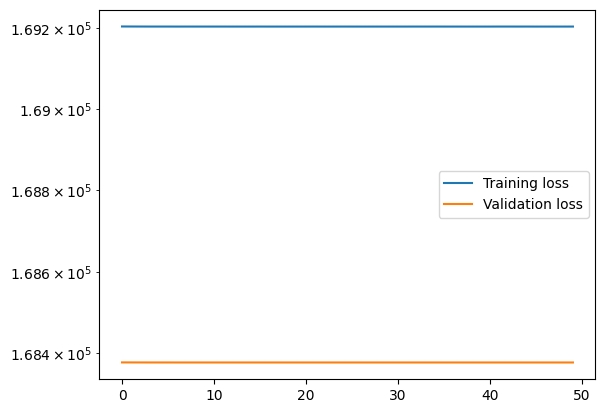

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.yscale('log')
plt.show()

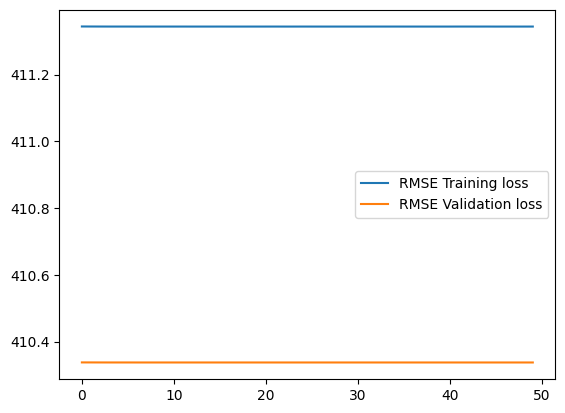

In [ ]:
# Plot the RMSE loss

plt.plot(np.sqrt(history.history['loss']), label='RMSE Training loss')
plt.plot(np.sqrt(history.history['val_loss']), label='RMSE Validation loss')
plt.legend()
plt.show()


In [ ]:
def plot_prediction(y_pred, y_test, title):
    plt.figure(figsize=(20,10))
    plt.plot(y_pred, label='Prediction')
    plt.plot(y_test, label='Actual')
    plt.legend()
    plt.title(title)
    plt.show()

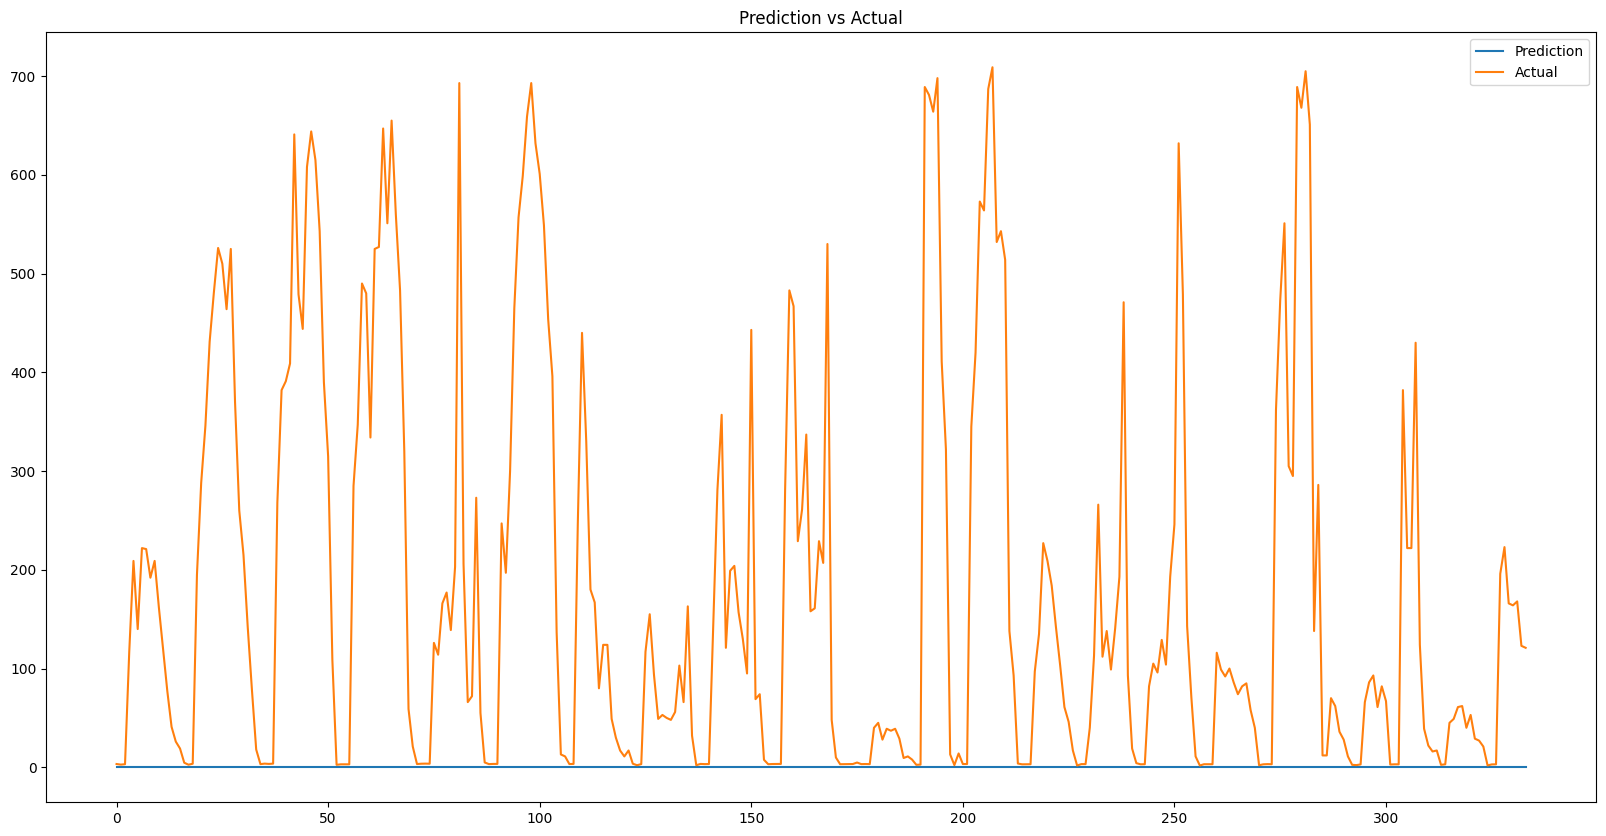

In [ ]:
plot_prediction(y_pred, y_test, 'Prediction vs Actual')